# LFRic W1/W2 Vector field on the cubed-sphere
This notebook shows how to interpolate a vector field defined on a cubed-sphere onto a regular lon-lat grid. The components of the vector field are staggered according to either Arakawa C (W2) or D (W1). For an orthogonal cell:

In [1]:
# Arakawa C or LFRic W2 space
# o---v----o
# |        |
# u        u
# |        |
# o---v----o

# Arakawa D or LFRic W1 space
# o---u----o
# |        |
# v        v
# |        |
# o---u----o

A critical aspect of mimetic interpolation is that the interpolating functions are vectors. However, they are different for W1 and W2 fields.

In [2]:
import mint
import numpy

## Load the grid from the Ugrid file

In [3]:
# the Ugrid file containing the grid and the wind velocities
src_filename = '../../data/lfric_diag_wind.nc'
src_meshname = 'Mesh2d'

# instantiate the grid object
src_grid = mint.Grid()

# these flags are required for rectilinear grids
src_grid.setFlags(fixLonAcrossDateline=1, averageLonAtPole=1)

# load the grid form the Ugrid file. Note we need to specify 
# the mesh name as well since the Ugrid file may contain several
# grids
src_grid.loadFromUgrid2D(src_filename + '$' + src_meshname)

# it's good practice to check that the grid object is valid,
# we don't want butterfly cells
num_bad_cells = src_grid.check()
print(f'num bad cells = {num_bad_cells}')

num bad cells = 0


## Read the wind components
LFRic stores the wind components (u1, u2) on edges of the 2d horizontal grid. 

In [4]:
import netCDF4
# get the velocities
nc = netCDF4.Dataset(src_filename)

# eastward wind
u1 = nc.variables['u1'][:]
# northward wind
u2 = nc.variables['u2'][:]

# longitudes and latitudes at cell vertices
lon = nc.variables['Mesh2d_node_x']
lat = nc.variables['Mesh2d_node_y']

# edge to node connectivity
edge_node_connect = nc.variables['Mesh2d_edge_nodes']

## Compute the edge/face integrals of the vector field
This can be done either in lon-lat or in Cartesian coordinates. 

In [5]:
# choose the time and elevation slice
itime = 0
iz = 0
ue_integrated_lonlat = mint.getIntegralsInLonLat(lon, lat, edge_node_connect,
                                                 u1[itime, iz,:], u2[itime, iz,:], w1=True)
ue_integrated_xyz = mint.getIntegralsInXYZ(lon, lat, edge_node_connect,
                                           u1[itime, iz,:], u2[itime, iz,:], w1=True)
uf_integrated_lonlat = mint.getIntegralsInLonLat(lon, lat, edge_node_connect, 
                                                 u1[itime, iz,:], u2[itime, iz,:], w1=False)
uf_integrated_xyz = mint.getIntegralsInXYZ(lon, lat, edge_node_connect, u1[itime, iz,:], 
                                           u2[itime, iz,:], w1=False)

## Create the set of target points

In [6]:
llon, llat = numpy.meshgrid(numpy.linspace(-180., 180., 40), numpy.linspace(-80., 80., 20))
ntarget = llon.shape[0] * llon.shape[1]
target_points = numpy.zeros((ntarget, 3), numpy.float64)
target_points[:, 0] = llon.flat
target_points[:, 1] = llat.flat

## Interpolate the W1 and W2 fields onto the target points

In [7]:
# create a vector interpolator
vi = mint.VectorInterp()
vi.setGrid(src_grid)
vi.buildLocator(numCellsPerBucket=10)
vi.findPoints(target_points, tol2=1.e-10)
# placement = 1 means data use a unique edge placement
edgeVectors_lonlat = vi.getEdgeVectors(ue_integrated_lonlat, placement=1)
edgeVectors_xyz = vi.getEdgeVectors(ue_integrated_xyz, placement=1)
faceVectors_lonlat = vi.getFaceVectors(uf_integrated_lonlat, placement=1)
faceVectors_xyz = vi.getFaceVectors(uf_integrated_xyz, placement=1)

Below are the interpolated vector fields for W1 (top) and (W2). On the left (right), a lat-lon (Cartesian) coordinate system was used to compute the field integral along horizontal edges. Most of the differences are near the poles.

The differences between W1 and W2 interpolation are most visible in the high latitudes where the panels of the cubed sphere join. 

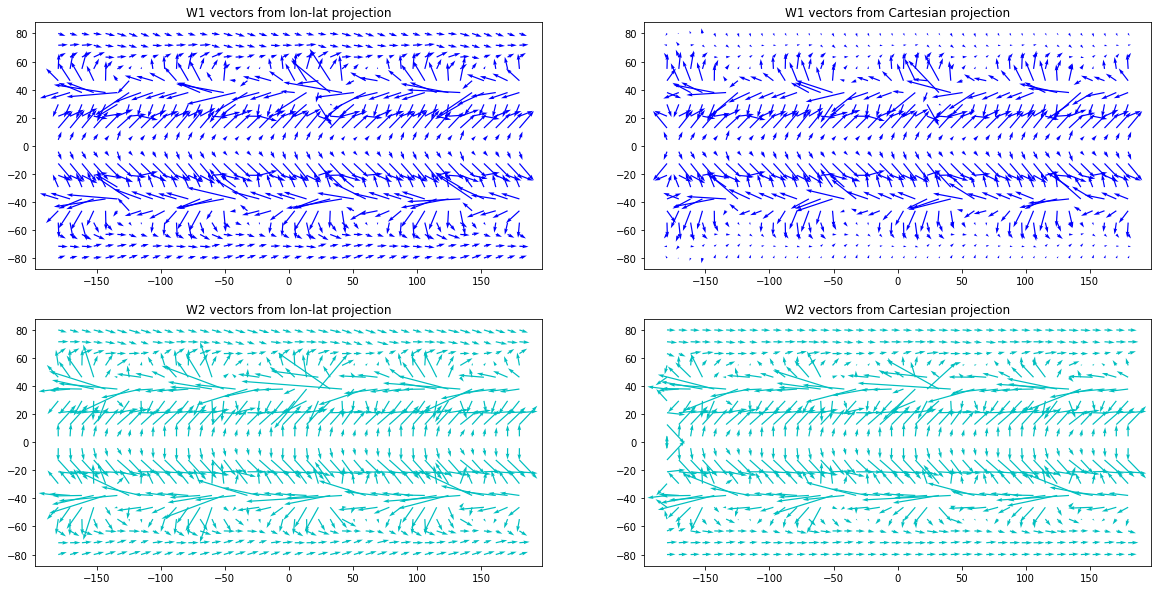

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
from matplotlib import pylab
scale = 500000

fig, ((ax1, ax2), (ax3, ax4)) = pylab.subplots(2, 2)

ax1.quiver(target_points[:, 0], target_points[:, 1], edgeVectors_lonlat[:, 0], edgeVectors_lonlat[:, 1], 
           color='b', scale=scale)
ax1.set_title('W1 vectors from lon-lat projection')

ax2.quiver(target_points[:, 0], target_points[:, 1], edgeVectors_xyz[:, 0], edgeVectors_xyz[:, 1], 
           color='b', scale=scale)
ax2.set_title('W1 vectors from Cartesian projection')

ax3.quiver(target_points[:, 0], target_points[:, 1], faceVectors_lonlat[:, 0], faceVectors_lonlat[:, 1], 
           color='c', scale=scale)
ax3.set_title('W2 vectors from lon-lat projection')

ax4.quiver(target_points[:, 0], target_points[:, 1], faceVectors_xyz[:, 0], faceVectors_xyz[:, 1], 
           color='c', scale=scale)
ax4.set_title('W2 vectors from Cartesian projection')

pylab.show()